# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [2]:
import time
start = time.time()

import sys
sys.path.append('../../ABEL/')
from abel import *
end = time.time()
print(end-start, ' sek')

%load_ext autoreload
%autoreload 2

20.93619680404663  sek


In [10]:
import numpy as np
import scipy.constants as SI 
import abel.utilities.plasma_physics as pp
import scipy.special as sc
import matplotlib.pyplot as plt

### Define the linac and beams

In [11]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 # 10e-15 # [m]
driver.symmetrize = True
driver.seed = 1
#drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######


# define stage
stage = StageQuasistatic2d()
#stage = StagePrtclTransWakeInstability()                      #######
#stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.length = 11 # [m]
stage.nom_energy_gain = 31.9e9 # [eV]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 1
stage.enable_radiation_reaction = True
stage.save_evolution = False
if stage.enable_radiation_reaction == False:
    stage.save_evolution = False

# define first stage (half length)
first_stage = StageQuasistatic2d()
#first_stage = StagePrtclTransWakeInstability()                      #######
#first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.enable_radiation_reaction = stage.enable_radiation_reaction
first_stage.save_evolution = stage.save_evolution

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.01
source.bunch_length = 28e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
print(source.beta_x*np.sqrt(source.emit_nx/(source.energy*SI.e/SI.m_e/SI.c**2)))
source.num_particles = 50000
source.jitter.t = driver.jitter.t
source.symmetrize = True
source.seed = driver.seed
beam = source.track()

"""
main_gamma = energy2gamma(source.energy)
main_sigma_x = np.sqrt(source.emit_nx/main_gamma*source.beta_x)  # [m]
main_sigma_y = np.sqrt(source.emit_ny/main_gamma*source.beta_y)  # [m]
source.x_offset = main_sigma_x*0.1  # [m]
source.y_offset = main_sigma_y*0.1  # [m]
"""
# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1.  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages: int = 16*3
shots = 1

2.125637304632815e-06


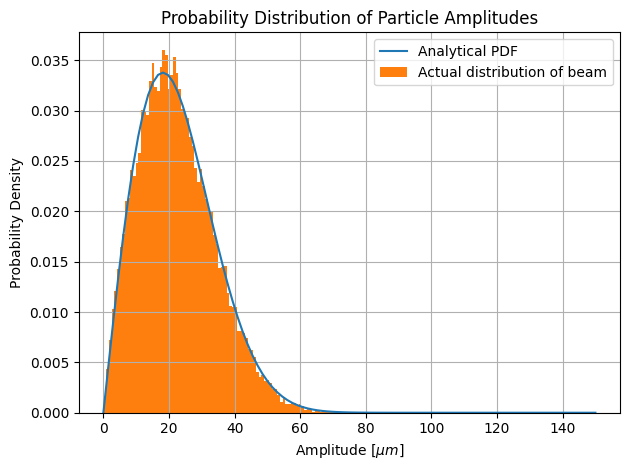

In [24]:
#plt.hist(beam.xs()**2, bins = 100)
x_2 = np.linspace(0,2e-9,100)
gamma = source.energy*SI.e/SI.m_e/SI.c**2
kp = pp.k_p(stage.plasma_density)
#plt.plot(x_2, np.exp(-x_2/(np.sqrt(2/gamma)*source.emit_nx/kp)))
#plt.yscale('log')
sig_x = np.sqrt(np.sqrt(2/gamma)*source.emit_nx/kp)*1e6
fig, ax = plt.subplots(tight_layout = True)
x_offset = 10


A = np.sqrt((beam.xs()+x_offset*1e-6)**2 + beam.xps()**2*(source.beta_x)**2)*1e6
A_lin = np.linspace(0,15e-5, 100)*1e6
I_0 = sc.iv(0,x_offset*A_lin/sig_x**2)

A_prob = A_lin/sig_x**2*I_0*np.exp(-0.5*(A_lin**2+x_offset**2)/sig_x**2)
ax.plot(A_lin,A_prob, label = 'Analytical PDF')
ax.hist(A, bins = 100, density = True, stacked=True, label = 'Actual distribution of beam')
ax.grid()
ax.set_xlabel('Amplitude [$\mu m$]')
ax.set_ylabel('Probability Density')
ax.set_title('Probability Distribution of Particle Amplitudes')
ax.legend()
plt.show()
#fig.savefig('PDF_amplitudes')
#print('sig_x² = ', np.sqrt(2/gamma)*source.emit_nx/kp)
#print(np.sqrt(np.mean(A**2)))
#print((np.mean(A**2))/sig_x**2)
#print(np.trapz(A_lin/sig_x**2*np.exp(-0.5*A_lin**2/sig_x**2),A_lin))

### Run simulations

In [31]:
start = time.time()
linac.run(f'linac_example_new_solver_RR_{stage.enable_radiation_reaction}\
_stages_{linac.num_stages}', num_shots=shots, overwrite=False, parallel=False);
end = time.time()

print((end - start)/60, ' min') # time in minutes

>> SHOT 1 already exists and will not be overwritten.
0.021203033129374185  min


### Plot the wakefield

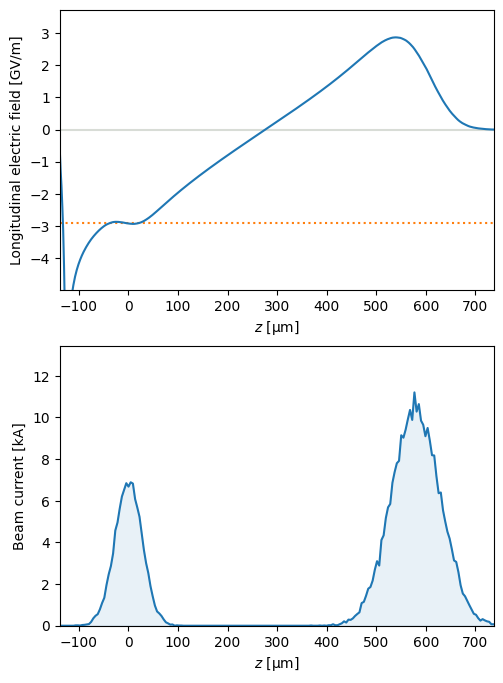

In [4]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

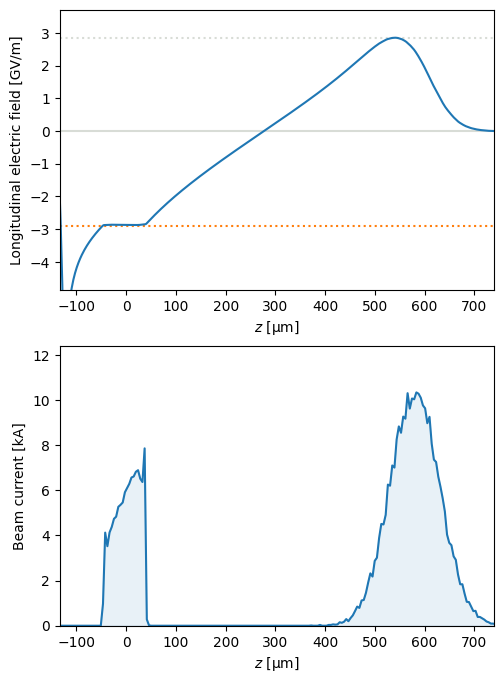

In [5]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

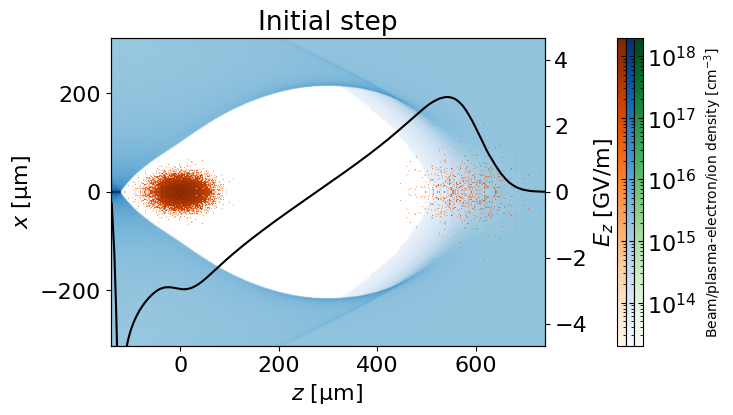

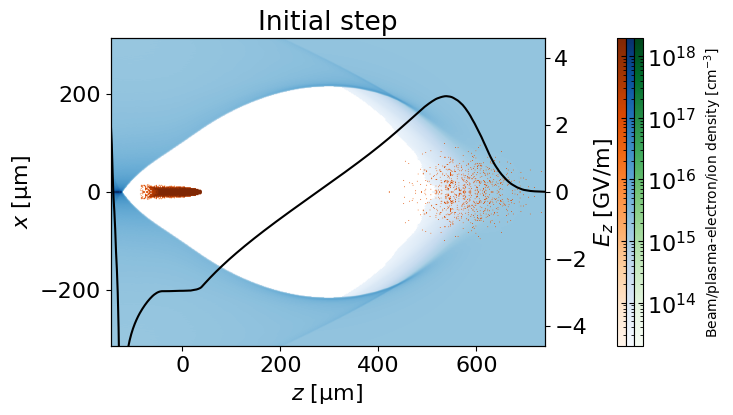

In [32]:
wake0 = linac.stages[0].plot_wake()
wake_final = linac.stages[-1].plot_wake()
if linac.num_stages < 17:
    wake0.savefig(f'Plots/New_Params/wake0_new_params_RR_{stage.enable_radiation_reaction}_stages_{linac.num_stages}', bbox_inches='tight')
    wake_final.savefig(f'Plots/New_Params/wake_final_new_params_RR_{stage.enable_radiation_reaction}_stages_{linac.num_stages}', bbox_inches='tight')
else:
    wake_final.savefig(f'Plots/New_Params/wake_final_new_params_RR_{stage.enable_radiation_reaction}_stages_{linac.num_stages}', bbox_inches='tight')

In [7]:
#fig = linac.stages[0].plot_evolution()
fig_last = linac.stages[-1].plot_evolution()

No evolution calculated


### Plot beam evolution and survey

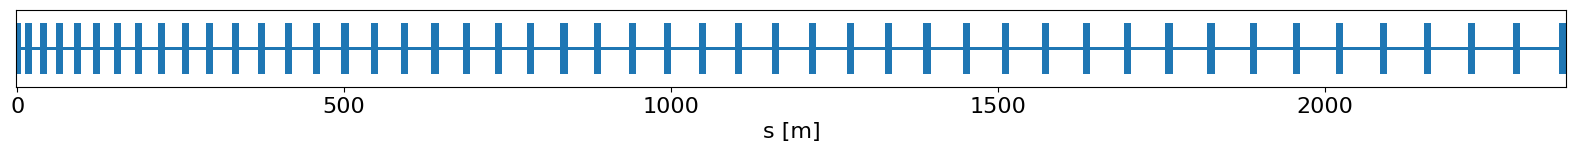

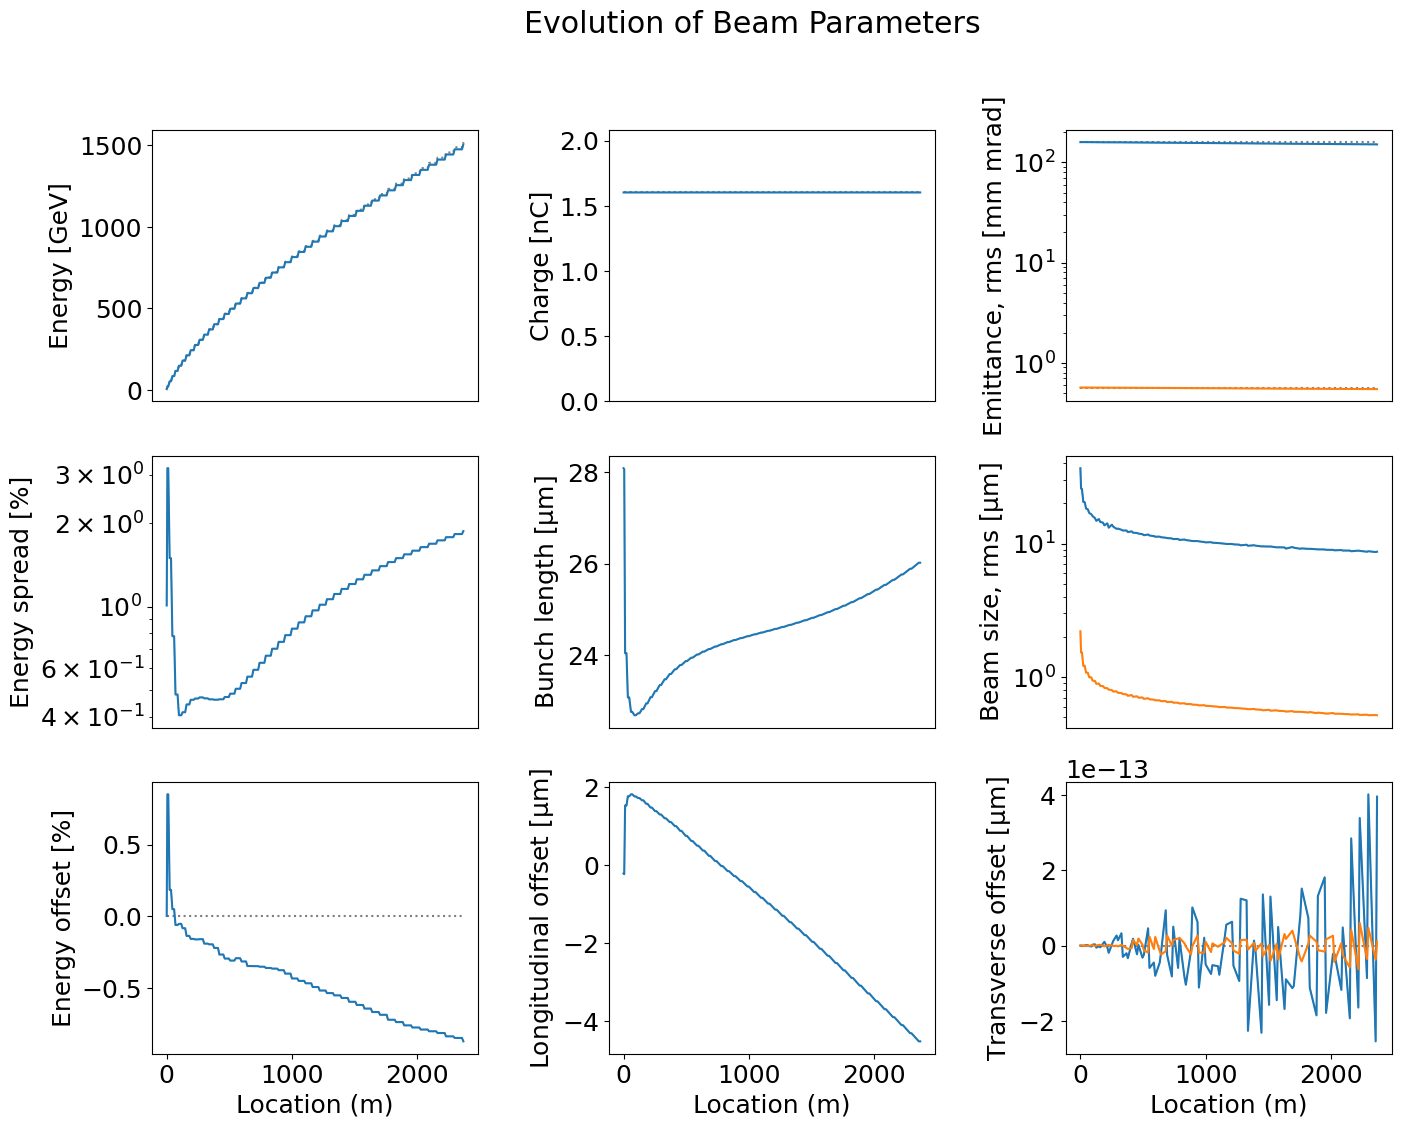

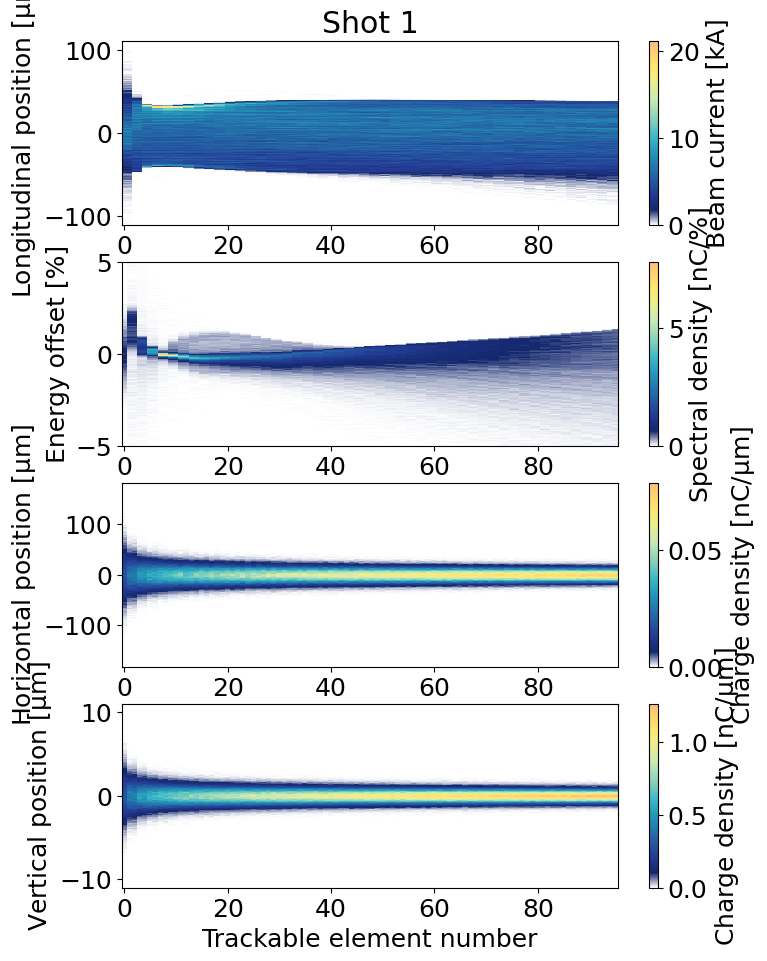

In [33]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
beam_evolution = linac.plot_evolution(use_stage_nums=False)
beam_evolution.savefig(f"Plots/New_Params/beam_evolution_new_params_RR_{stage.enable_radiation_reaction}\
_stages_{linac.num_stages}_test.png", bbox_inches = 'tight')
linac[0].plot_waterfalls()


KeyboardInterrupt: 

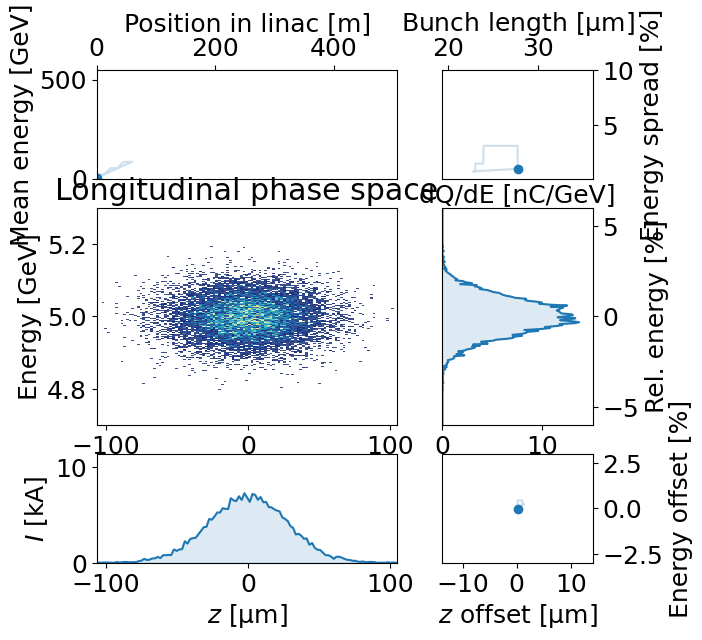

In [16]:
gif = linac.animate_lps()

![](run_data/linac_example/plots/lps_shot0.gif)

In [10]:
stage_num = 15
shot_num = 0
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

In [11]:
Final_energies = [linac.get_beam(-1, shot = i).energy()/1e9 for i in range(shots)]
Final_spread = [linac.get_beam(-1, shot = i).rel_energy_spread() for i in range(shots)]
energy_standard_error = np.std(Final_energies)
mean_energy = np.mean(Final_energies)
print('RMS energy spread is ', energy_standard_error, 'Mean final energy is ', mean_energy)

gamma = source.energy*SI.e/SI.m_e/SI.c**2
kp = pp.k_p(stage.plasma_density)
k_beta = kp/np.sqrt(2*gamma)
sig_x2 = (np.sqrt(2/gamma)*source.emit_nx/kp)
sig_y2 = (np.sqrt(2/gamma)*source.emit_ny/kp)

Expected_energy_loss = SI.e**2/6/np.pi/SI.epsilon_0 * (gamma*k_beta)**4*(sig_x2+sig_y2)*stage.length
Expected_energy_spread = SI.e**2/6/np.pi/SI.epsilon_0 * (gamma*k_beta)**4*\
np.sqrt((sig_x2**2+sig_y2**2))*stage.length/(source.energy*SI.e)

print('expected energy loss is ', Expected_energy_loss/SI.e/1e9)
print('expected energy spread is ', Expected_energy_spread)
print('actual energy spread is ', np.mean(Final_spread), \
      'standard error in energy spread is ', np.std(Final_spread))

RMS energy spread is  0.0 Mean final energy is  499.0390241173483
expected energy loss is  0.00034580244883852687
expected energy spread is  6.891969444385443e-05
actual energy spread is  0.0023163307870754813 standard error in energy spread is  0.0
